In [31]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import re
from io import StringIO

PULLEY_RADIUS = 3.5


def theta_to_xy(theta_l, theta_r):
        '''Takes motor angles in degrees and converts them into
        cartesian position of the mallet in centimeters'''
        x = (theta_l + theta_r) * PULLEY_RADIUS * np.pi / 360
        y = (theta_l - theta_r) * PULLEY_RADIUS * np.pi / 360

        return x, y

def xy_to_theta(x, y):
        '''Takes cartesian position of the mallet (x, y) in centimeters and converts
        it into motor angles in encoder ticks (2048 ticks per revolution)'''
        theta_l = (x + y) / PULLEY_RADIUS * 360 / (2*np.pi)
        theta_r = (x - y) / PULLEY_RADIUS * 360 / (2*np.pi)

        return theta_l, theta_r

csv_signature = "BEGIN CSV"

In [32]:
all_files = os.listdir('data')
most_recent_file = all_files[-185] # most recent file will be last alphabetically

with open('data/' + most_recent_file, 'r', encoding='utf-8') as f:
    file_contents = f.read()

content_begin = re.search(csv_signature, file_contents)
content_end = re.search(r'\n.*$', file_contents)

if content_begin is None:
    print("Did not find CSV signature in file")
    exit(1)

data = file_contents[content_begin.end():content_end.start()+1]

table = pd.read_csv(StringIO(data))

print(table.columns.values)

table['X_Error(cm)'] = [theta_to_xy(l,r)[0] for l, r in zip(table['Left_Error(deg)'], table['Right_Error(deg)'])]
table['Y_Error(cm)'] = [theta_to_xy(l,r)[1] for l, r in zip(table['Left_Error(deg)'], table['Right_Error(deg)'])]

table['X_Actual(cm)'] = table['X_Target(cm)'] - table['X_Error(cm)']
table['Y_Actual(cm)'] = table['Y_Target(cm)'] - table['Y_Error(cm)']

table['Left_Target(deg)'] = [xy_to_theta(l,r)[0] for l, r in zip(table['X_Target(cm)'], table['Y_Target(cm)'])]
table['Right_Target(deg)'] = [xy_to_theta(l,r)[1] for l, r in zip(table['X_Target(cm)'], table['Y_Target(cm)'])]

table['Left_Actual(deg)'] = table['Left_Target(deg)'] - table['Left_Error(deg)']
table['Right_Actual(deg)'] = table['Right_Target(deg)'] - table['Right_Error(deg)']

table['delta t(ms)'] = table['Time(ms)'].diff()

table['X_Velocity(cm/s)'] = table['X_Actual(cm)'].diff() / table['delta t(ms)'] * 1000
table['X_Target_Velocity(cm/s)'] = table['X_Target(cm)'].diff() / table['delta t(ms)'] * 1000

table['Y_Velocity(cm/s)'] = table['Y_Actual(cm)'].diff() / table['delta t(ms)'] * 1000
table['Y_Target_Velocity(cm/s)'] = table['Y_Target(cm)'].diff() / table['delta t(ms)'] * 1000

if set(['Left_Feed_Forward','Right_Feed_Forward']) <= set(table.columns.values):
    table['Left_Total_PWM'] = table['Left_Feed_Forward'] + table['Left_PID']
    table['Right_Total_PWM'] = table['Right_Feed_Forward'] + table['Right_PID']

t_path_change = table['delta t(ms)'].argmax()
print(table['Time(ms)'][t_path_change])
print(table['X_Error(cm)'][t_path_change - 1])


['Time(ms)' 'X_Target(cm)' 'Y_Target(cm)' 'Left_Error(deg)'
 'Right_Error(deg)' 'Left_PID' 'Right_PID' 'Left_Feed_Forward'
 'Right_Feed_Forward']
803.26
-0.12217304763960307


20230326_time2246.csv


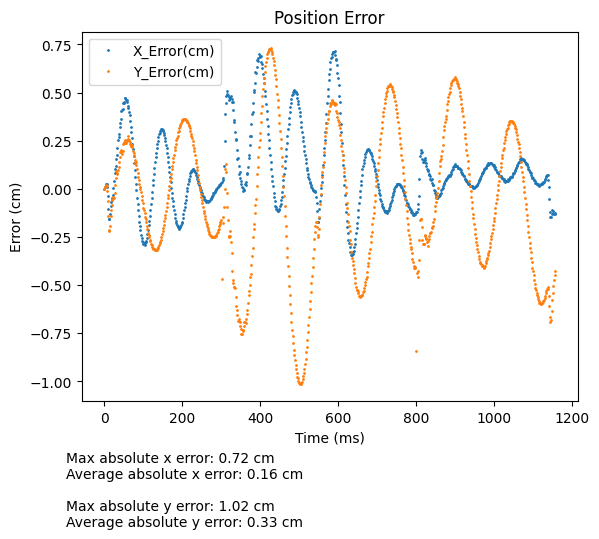

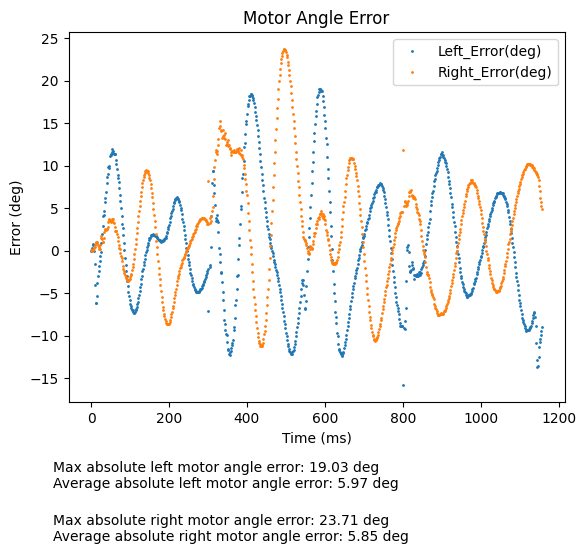

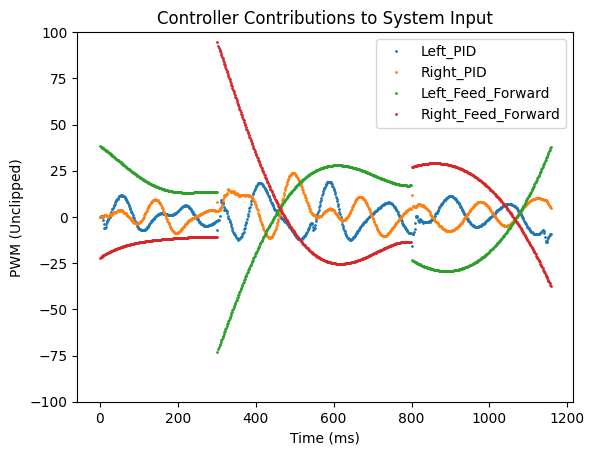

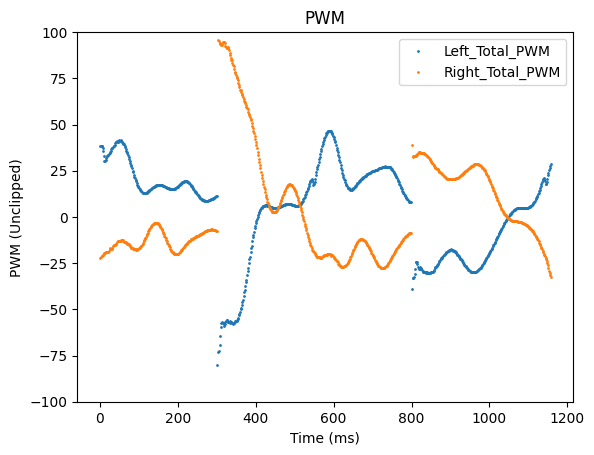

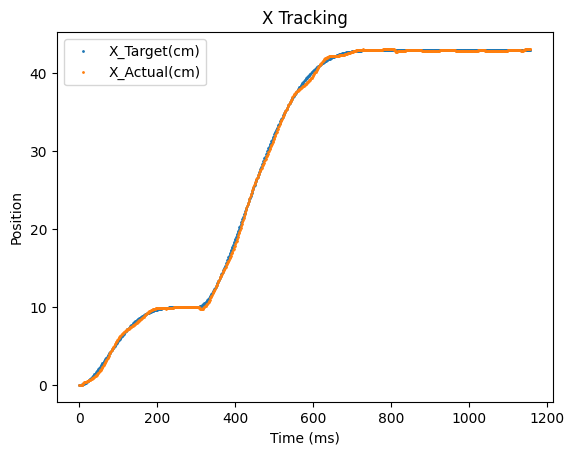

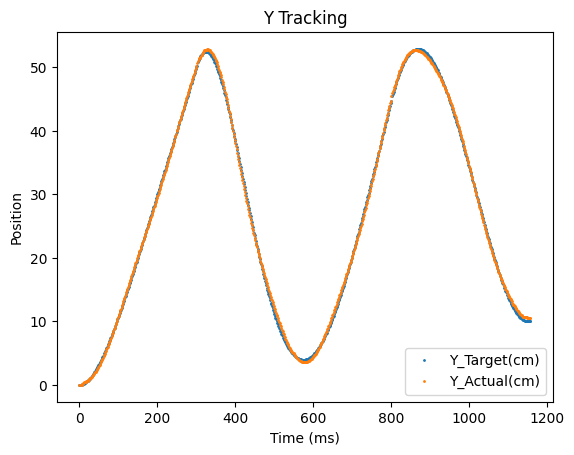

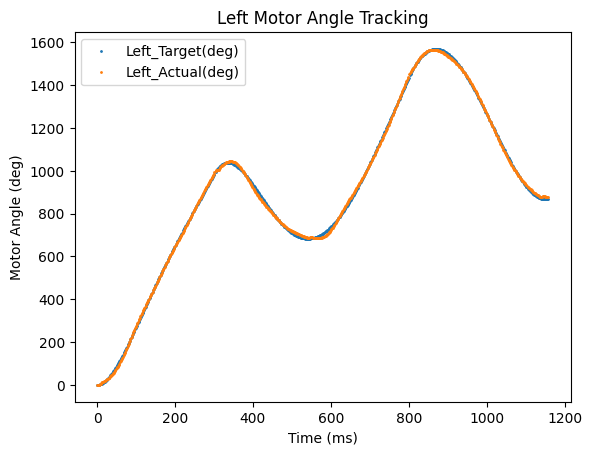

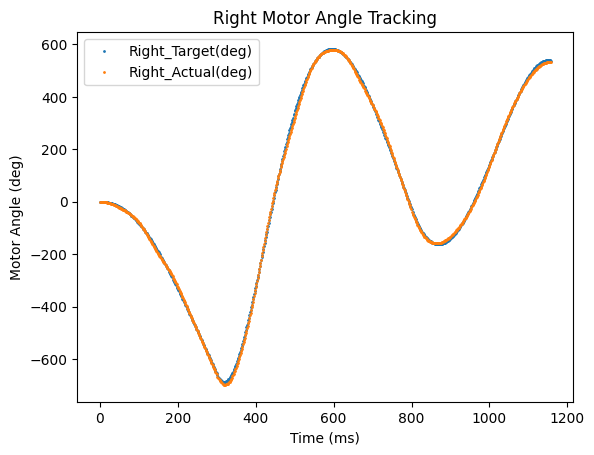

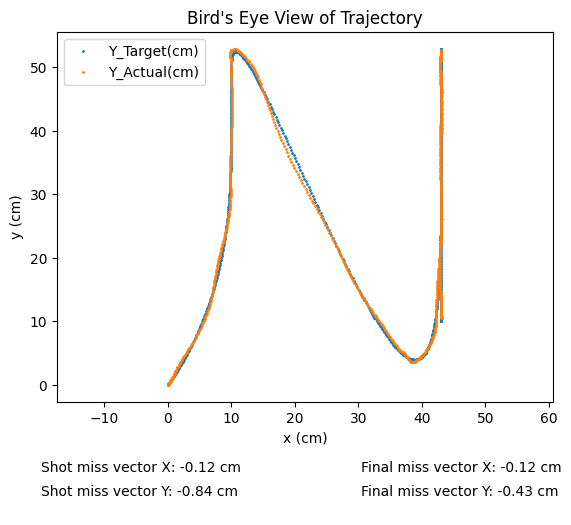

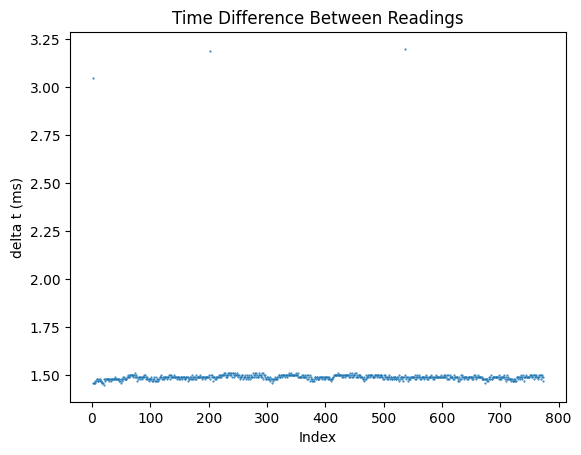

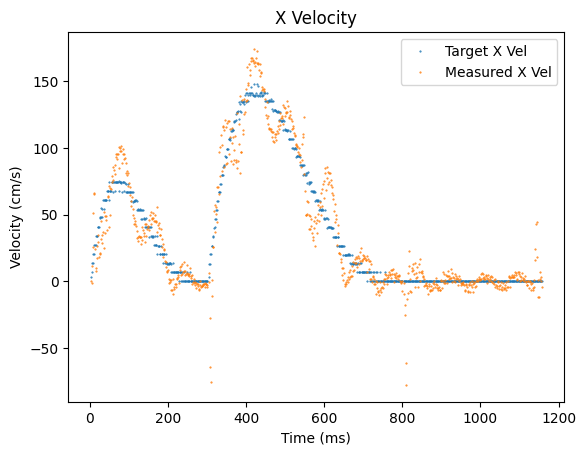

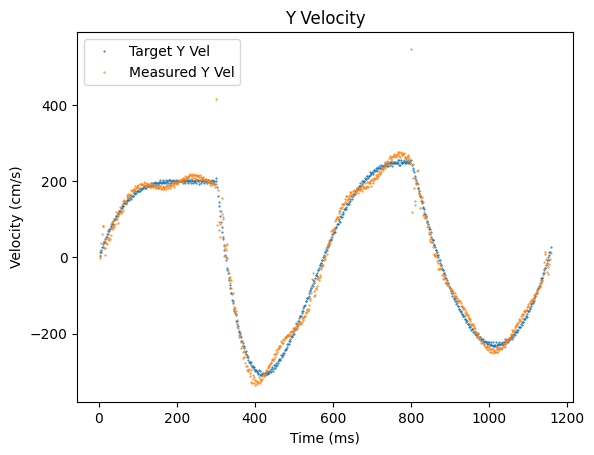

In [33]:
plt.figure()
plotted_values = ['X_Error(cm)', 'Y_Error(cm)']

for val in plotted_values:
    plt.plot(table['Time(ms)'], table[val], marker='o', markersize=1, linestyle='none')

plt.legend(plotted_values)
plt.title('Position Error')
plt.xlabel('Time (ms)')
plt.ylabel('Error (cm)')

plt.figtext(0.1, -0.05, f"\nMax absolute x error: {round(table['X_Error(cm)'].abs().max(),2)} cm\n" \
    f"Average absolute x error: {round(table['X_Error(cm)'].abs().mean(),2)} cm")
plt.figtext(0.1, -0.15, f"\nMax absolute y error: {round(table['Y_Error(cm)'].abs().max(),2)} cm\n" \
    f"Average absolute y error: {round(table['Y_Error(cm)'].abs().mean(),2)} cm")


plt.figure()
plotted_values = ['Left_Error(deg)', 'Right_Error(deg)']

for val in plotted_values:
    plt.plot(table['Time(ms)'], table[val], marker='o', markersize=1, linestyle='none')

plt.legend(plotted_values)
plt.title('Motor Angle Error')
plt.xlabel('Time (ms)')
plt.ylabel('Error (deg)')

plt.figtext(0.1, -0.07, f"\nMax absolute left motor angle error: {round(table['Left_Error(deg)'].abs().max(),2)} deg\n" \
    f"Average absolute left motor angle error: {round(table['Left_Error(deg)'].abs().mean(),2)} deg")
plt.figtext(0.1, -0.18, f"\nMax absolute right motor angle error: {round(table['Right_Error(deg)'].abs().max(),2)} deg\n" \
    f"Average absolute right motor angle error: {round(table['Right_Error(deg)'].abs().mean(),2)} deg")

if set(['Left_PWM','Right_PWM']) <= set(table.columns.values):
    plt.figure()
    plotted_values = ['Left_PWM','Right_PWM']

    for val in plotted_values:
        plt.plot(table['Time(ms)'], table[val], marker='o', markersize=1, linestyle='none')

    plt.legend(plotted_values)
    plt.title('PWM')
    plt.xlabel('Time (ms)')
    plt.ylabel('PWM (-100 to 100)')

if set(['Left_PID','Right_PID','Left_Feed_Forward','Right_Feed_Forward']) <= set(table.columns.values):
    plt.figure()
    plotted_values = ['Left_PID','Right_PID','Left_Feed_Forward','Right_Feed_Forward']

    for val in plotted_values:
        plt.plot(table['Time(ms)'], table[val], marker='o', linestyle='none', markersize=1)

    plt.legend(plotted_values)
    plt.title('Controller Contributions to System Input')
    plt.xlabel('Time (ms)')
    plt.ylabel('PWM (Unclipped)')
    plt.ylim([-100, 100])


if set(['Left_PID','Right_PID','Left_Feed_Forward','Right_Feed_Forward']) <= set(table.columns.values):
    plt.figure()
    plotted_values = ['Left_Total_PWM','Right_Total_PWM']

    for val in plotted_values:
        plt.plot(table['Time(ms)'], table[val], marker='o', linestyle='none', markersize=1)

    plt.legend(plotted_values)
    plt.title('PWM')
    plt.xlabel('Time (ms)')
    plt.ylabel('PWM (Unclipped)')
    plt.ylim([-100, 100])


plt.figure()
plotted_values = ['X_Target(cm)', 'X_Actual(cm)']

for val in plotted_values:
    plt.plot(table['Time(ms)'], table[val], marker='o', linestyle='none', markersize=1)

plt.legend(plotted_values)
plt.title('X Tracking')
plt.xlabel('Time (ms)')
plt.ylabel('Position')

plt.figure()
plotted_values = ['Y_Target(cm)', 'Y_Actual(cm)']

for val in plotted_values:
    plt.plot(table['Time(ms)'], table[val], marker='o', linestyle='none', markersize=1)

plt.legend(plotted_values)
plt.title('Y Tracking')
plt.xlabel('Time (ms)')
plt.ylabel('Position')


plt.figure()
plotted_values = ['Left_Target(deg)', 'Left_Actual(deg)']

for val in plotted_values:
    plt.plot(table['Time(ms)'], table[val], marker='o', linestyle='none', markersize=1)

plt.legend(plotted_values)
plt.title('Left Motor Angle Tracking')
plt.xlabel('Time (ms)')
plt.ylabel('Motor Angle (deg)')


plt.figure()
plotted_values = ['Right_Target(deg)', 'Right_Actual(deg)']

for val in plotted_values:
    plt.plot(table['Time(ms)'], table[val], marker='o', linestyle='none', markersize=1)

plt.legend(plotted_values)
plt.title('Right Motor Angle Tracking')
plt.xlabel('Time (ms)')
plt.ylabel('Motor Angle (deg)')


plt.figure()
plotted_values = ['Y_Target(cm)', 'Y_Actual(cm)']

plt.plot(table['X_Target(cm)'], table['Y_Target(cm)'], marker='o', linestyle='none', markersize=1)
plt.plot(table['X_Actual(cm)'], table['Y_Actual(cm)'], marker='o', linestyle='none', markersize=1)

plt.legend(plotted_values)
plt.axis('equal')
plt.title("Bird's Eye View of Trajectory")
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')

plt.figtext(0.1, -0.07, f"\nShot miss vector X: {round(table['X_Error(cm)'][t_path_change - 1],2)} cm\n")
plt.figtext(0.1, -0.12, f"\nShot miss vector Y: {round(table['Y_Error(cm)'][t_path_change - 1],2)} cm\n")

plt.figtext(0.6, -0.07, f"\nFinal miss vector X: {round(table['X_Error(cm)'].iloc[-1],2)} cm\n")
plt.figtext(0.6, -0.12, f"\nFinal miss vector Y: {round(table['Y_Error(cm)'].iloc[-1],2)} cm\n")


plt.figure()
plt.plot(table['delta t(ms)'], marker='.', linestyle='none', markersize=1)
plt.title('Time Difference Between Readings')
plt.xlabel('Index')
plt.ylabel('delta t (ms)')


plt.figure()
plt.plot(table['Time(ms)'], table['X_Target_Velocity(cm/s)'], marker='.', linestyle='none', markersize=1)
plt.plot(table['Time(ms)'], table['X_Velocity(cm/s)'], marker='.', linestyle='none', markersize=1)
plt.legend(['Target X Vel', 'Measured X Vel'])
plt.title('X Velocity')
plt.xlabel('Time (ms)')
plt.ylabel('Velocity (cm/s)')


plt.figure()
plt.plot(table['Time(ms)'], table['Y_Target_Velocity(cm/s)'], marker='.', linestyle='none', markersize=1)
plt.plot(table['Time(ms)'], table['Y_Velocity(cm/s)'], marker='.', linestyle='none', markersize=1)
plt.legend(['Target Y Vel', 'Measured Y Vel'])
plt.title('Y Velocity')
plt.xlabel('Time (ms)')
plt.ylabel('Velocity (cm/s)')

print(most_recent_file)